In [24]:
import os
import torch
import torchvision

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class CustCoco(torchvision.datasets.CocoDetection):
    def __init__(self,root, ann_file, transforms=None):
        super().__init__(root, ann_file, transforms)
    
    def __getitem__(self, index: int):
        image, target = super().__getitem__(index)
        img = torchvision.transforms.PILToTensor()(image)
        return img, target

In [28]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 4  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [29]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [21]:
# Since v0.15.0 torchvision provides `new Transforms API <https://pytorch.org/vision/stable/transforms.html>`_
# to easily write data augmentation pipelines for Object Detection and Segmentation tasks.
#
# Let’s write some helper functions for data augmentation /
# transformation:

from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


# Testing ``forward()`` method (Optional)
# ---------------------------------------
#
# Before iterating over the dataset, it's good to see what the model
# expects during training and inference time on sample data.
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = torchvision.datasets.wrap_dataset_for_transforms_v2(CustCoco('./train2','./train2/_annotations.coco.json', get_transform(train=True)),target_keys=['image_id','area','iscrowd','labels','boxes','masks'])
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [17]:
print(dataset[0])

(tensor([[[0.2667, 0.2471, 0.2314,  ..., 0.2039, 0.2078, 0.2157],
         [0.2431, 0.2314, 0.2235,  ..., 0.2078, 0.2157, 0.2235],
         [0.2392, 0.2314, 0.2314,  ..., 0.2078, 0.2157, 0.2235],
         ...,
         [0.1020, 0.0902, 0.0902,  ..., 0.1961, 0.1922, 0.1843],
         [0.1059, 0.0980, 0.0980,  ..., 0.1882, 0.1843, 0.1843],
         [0.1098, 0.0980, 0.0980,  ..., 0.1804, 0.1804, 0.1843]],

        [[0.2667, 0.2471, 0.2314,  ..., 0.2039, 0.2078, 0.2157],
         [0.2431, 0.2314, 0.2235,  ..., 0.2078, 0.2157, 0.2235],
         [0.2392, 0.2314, 0.2314,  ..., 0.2078, 0.2157, 0.2235],
         ...,
         [0.1020, 0.0902, 0.0902,  ..., 0.1961, 0.1922, 0.1843],
         [0.1059, 0.0980, 0.0980,  ..., 0.1882, 0.1843, 0.1843],
         [0.1098, 0.0980, 0.0980,  ..., 0.1804, 0.1804, 0.1843]],

        [[0.2667, 0.2471, 0.2314,  ..., 0.2039, 0.2078, 0.2157],
         [0.2431, 0.2314, 0.2235,  ..., 0.2078, 0.2157, 0.2235],
         [0.2392, 0.2314, 0.2314,  ..., 0.2078, 0.2157, 0

In [18]:
# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(4.8364, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.5389, grad_fn=<DivBackward0>), 'loss_objectness': tensor(4.3535, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1433, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


Let’s now write the main function which performs the training and the
validation:



In [25]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 4
# use our dataset and defined transformations
dataset = torchvision.datasets.wrap_dataset_for_transforms_v2(CustCoco('./train2','./train2/_annotations.coco.json', get_transform(train=True)),target_keys=['image_id','area','iscrowd','labels','boxes','masks'])
dataset_test = torchvision.datasets.wrap_dataset_for_transforms_v2(CustCoco('./train2','./train2/_annotations.coco.json', get_transform(train=False)),target_keys=['image_id','area','iscrowd','labels','boxes','masks'])

# split the dataset in train and test set
#indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Epoch: [0]  [ 0/15]  eta: 0:02:03  lr: 0.000362  loss: 6.3619 (6.3619)  loss_classifier: 1.1237 (1.1237)  loss_box_reg: 0.7980 (0.7980)  loss_mask: 2.3468 (2.3468)  loss_objectness: 2.0465 (2.0465)  loss_rpn_box_reg: 0.0471 (0.0471)  time: 8.2617  data: 0.1434
Epoch: [0]  [10/15]  eta: 0:00:41  lr: 0.003930  loss: 3.4125 (3.9899)  loss_classifier: 0.8485 (0.8680)  loss_box_reg: 0.7439 (0.6500)  loss_mask: 1.0136 (1.3163)  loss_objectness: 0.8462 (1.0354)  loss_rpn_box_reg: 0.0924 (0.1202)  time: 8.3340  data: 0.4040
Epoch: [0]  [14/15]  eta: 0:00:07  lr: 0.005000  loss: 2.8593 (3.6619)  loss_classifier: 0.8485 (0.8772)  loss_box_reg: 0.7439 (0.6903)  loss_mask: 0.7449 (1.1262)  loss_objectness: 0.4114 (0.8382)  loss_rpn_box_reg: 0.0965 (0.1300)  time: 7.7607  data: 0.3152
Epoch: [0] Total time: 0:01:56 (7.7609 s / it)


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Test:  [ 0/29]  eta: 0:00:36  model_time: 1.0229 (1.0229)  evaluator_time: 0.1975 (0.1975)  time: 1.2516  data: 0.0312
Test:  [28/29]  eta: 0:00:01  model_time: 1.0081 (1.0611)  evaluator_time: 0.1717 (0.1865)  time: 1.4894  data: 0.2142
Test: Total time: 0:00:41 (1.4173 s / it)
Averaged stats: model_time: 1.0081 (1.0611)  evaluator_time: 0.1717 (0.1865)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | 

So after one epoch of training, we obtain a COCO-style mAP > 50, and
a mask mAP of 65.

But what do the predictions look like? Let’s take one image in the
dataset and verify

<img src="file://../../_static/img/tv_tutorial/tv_image05.png">




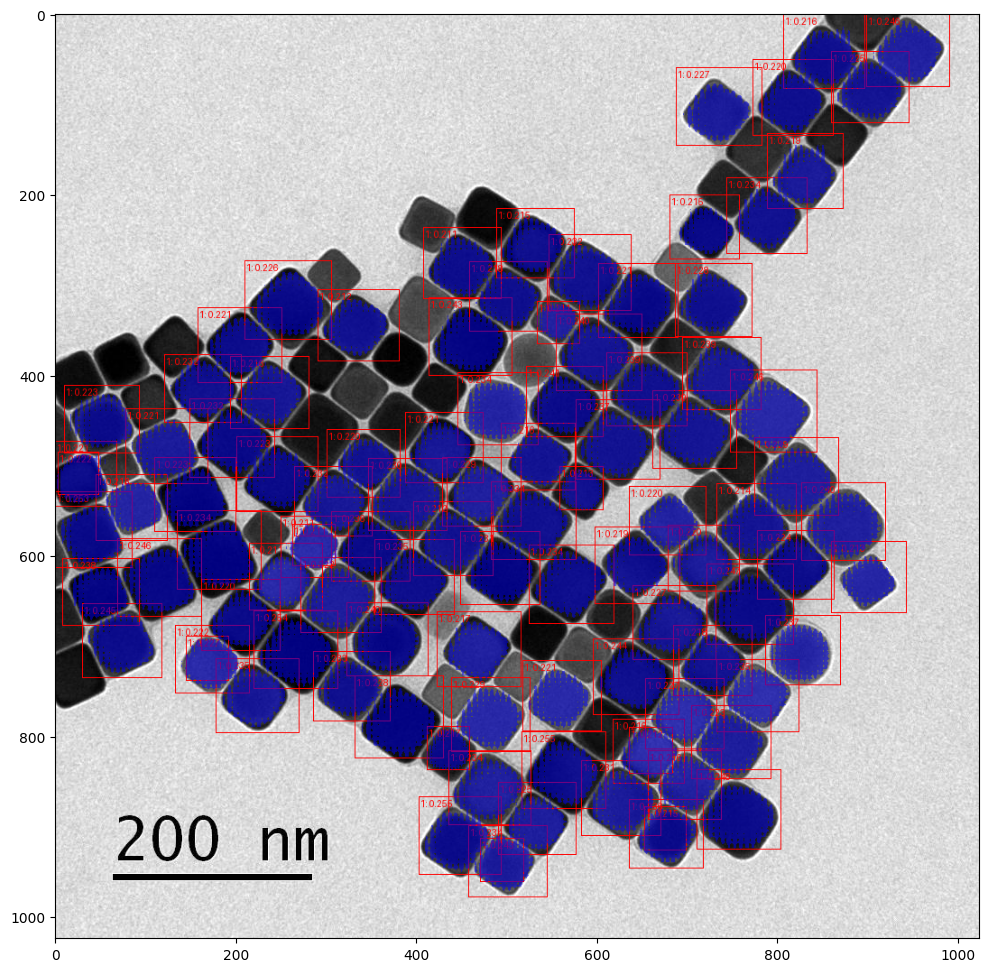

In [27]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("./train2/Cu-s-16_0004_jpg.rf.21708722aff4c9b4c45354b87d9330e9.jpg")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{label}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

The results look good!

## Wrapping up

In this tutorial, you have learned how to create your own training
pipeline for object detection models on a custom dataset. For
that, you wrote a ``torch.utils.data.Dataset`` class that returns the
images and the ground truth boxes and segmentation masks. You also
leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to
perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-GPU
training, check ``references/detection/train.py``, which is present in
the torchvision repository.

You can download a full source file for this tutorial
[here](https://pytorch.org/tutorials/_static/tv-training-code.py)_.
